In [1]:
import netCDF4 as nc
import numpy as np

from scipy import interpolate
import os
from datetime import datetime
import pandas as pd
import csv
import glob

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from pyproj import Proj

In [2]:
# A function that takes in viewing angle, ABI data, GLM data
def anglebin(Data_60,Data_50,Data_40,Data_30,Data_20,combo_data,angle):
    loc60 = np.where(angle>=60)[0]
    loc50 = np.where((angle>=50) & (angle<60))[0]
    loc40 = np.where((angle>=40) & (angle<50))[0]
    loc30 = np.where((angle>=30) & (angle<40))[0]
    loc20 = np.where((angle>=20) & (angle<30))[0]
    
    Data_60 = np.append(Data_60,combo_data[:,loc60],axis=1)
    Data_50 = np.append(Data_50,combo_data[:,loc50],axis=1)
    Data_40 = np.append(Data_40,combo_data[:,loc40],axis=1)
    Data_30 = np.append(Data_30,combo_data[:,loc30],axis=1)
    Data_20 = np.append(Data_20,combo_data[:,loc20],axis=1)
    
    return Data_60,Data_50,Data_40,Data_30,Data_20

In [3]:
def viewingangle(latP,lonP):
    R = 6.37*10**6 #Radius of the Earth (m)
    H = 35786023.0 #Height of satellite from Earth's surface (m)
    r = R + H      #Height of satellite from the center of the Earth (m)
    lonS = [-75.0] #Longitude of the satellite (deg)
    ratio = R/r
    
    #Converting to radians and making sure the longitudes are positive from east
    lonS = np.radians(pos_lon(lonS))
    lonP = np.radians(pos_lon(lonP))
    latP = np.radians(latP)
    #GEOMETRY (see notebook from 6/6 for diagram)
    gamma = np.arccos(np.cos(latP)*np.cos(lonS-lonP))
    d = r*np.sqrt(1+(ratio**2)-(2*ratio*np.cos(gamma)))
    v = np.arccos((r/d)*np.sin(gamma))
    v = np.degrees(v)
    
    return v

In [4]:
def pos_lon(lon):
    array = np.arange(0,len(lon),1)
    for i in array:
        if lon[i]<0:
            lon[i] = lon[i]+360
    return lon

In [5]:
#A function that takes in a netCDF Dataset and returns it x/y values as lon/lat
def latlon(nc_file):
    sat_h = nc_file.variables['goes_imager_projection'].perspective_point_height
    sat_lon = nc_file.variables['goes_imager_projection'].longitude_of_projection_origin
    sat_sweep = nc_file.variables['goes_imager_projection'].sweep_angle_axis
    
    X = nc_file.variables['x'][:] * sat_h
    Y = nc_file.variables['y'][:] * sat_h
    
    p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
    YY, XX = np.meshgrid(Y, X)
    lons, lats = p(XX, YY, inverse=True)
    
    return lons, lats

In [6]:
sns.set(color_codes=True)
sns.set(style='ticks')
colors = ['faded red', 'bluish']
xkcd = sns.xkcd_palette(colors)
sns.set_palette(xkcd)
#sns.palplot(sns.xkcd_palette(colors))

In [17]:
#ABI_loc = '/localdata/cases/20190403/ABI_tester/'
#GLM_loc = '/localdata/cases/20190403/GLM_tester/'

ABI_loc = '/localdata/cases/test_case/ABI/CTPC/'
GLM_loc = '/localdata/cases/test_case/GLM_grids/'
save_loc = '/localdata/cases/test_case/test_pics/'

NOTE: GLM will always be the frist row, with ABI as a the second row

In [18]:
times = []
Data_60 = np.empty((2,1),dtype=np.float16)
Data_50 = np.empty((2,1),dtype=np.float16)
Data_40 = np.empty((2,1),dtype=np.float16)
Data_30 = np.empty((2,1),dtype=np.float16)
Data_20 = np.empty((2,1),dtype=np.float16)


for file in sorted(os.listdir(ABI_loc)):
    #Loading in the ABI data
    ABI_data = nc.Dataset(ABI_loc+file, 'r')
    ABI_x = ABI_data.variables['x'][:] 
    ABI_y = ABI_data.variables['y'][:]
    ABI_var = ABI_data.variables['PRES'][:,:].T
    ABI_var = np.ma.filled(ABI_var,fill_value=0)
    
    #ABI time stuff
    ABI_time = datetime.strptime(ABI_data.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')
    times = np.append(times, ABI_time)
    print (ABI_time)
    YYYY = ABI_time.strftime('%Y')
    mm = ABI_time.strftime('%m') #month
    dd = ABI_time.strftime('%d')
    HH = ABI_time.strftime('%H')
    MM = ABI_time.strftime('%M') #Minute
    
    #Loading in the GLM data
    GLM_file = 'GLM-00-00_'+YYYY+mm+dd+'_'+HH+MM+'00_60_1src_056urad-dx_total_energy.nc'
    GLM_data = nc.Dataset(GLM_loc+GLM_file,'r')
    GLM_x = GLM_data.variables['x'][:]
    GLM_y = GLM_data.variables['y'][:]
    GLM_var = np.squeeze(GLM_data.variables['total_energy'][:,:]) #Kicks out the time dimension
    GLM_var = np.ma.filled(GLM_var,fill_value=0)
    
    #Matching the ABI grid to the GLM grid
    f = interpolate.interp2d(ABI_y,ABI_x,ABI_var, kind='linear')
    ABI_new = f(GLM_y,GLM_x) #Converting TO the GLM coordinates
    
    #Getting the lat and lons for the GLM data
    lons,lats = latlon(GLM_data)
    
    #Flattening variables to 1 dimension
    GLM_flatten = GLM_var.flatten()
    ABI_flatten = ABI_new.flatten()
    lats_flatten = lats.flatten()
    lons_flatten = lons.flatten()
    
    #Finding where the ABI/GLM data are zero/nonzero
    GLM_zloc = np.where(GLM_flatten==0)[0]
    ABI_zloc = np.where(ABI_flatten==0)[0]

    #Applying zeroes from one dataset to another
    ABI_flatten[GLM_zloc] = 0
    GLM_flatten[ABI_zloc] = 0
    
    #Finding the nonzero values from the cutdownvalues
    GLM_n2loc = np.where(GLM_flatten>0)[0]
    
    #Putting the data into their respective cutdown datasets
    GLM_cutdown = GLM_flatten[GLM_n2loc]
    ABI_cutdown = ABI_flatten[GLM_n2loc]
    lats_cutdown = lats_flatten[GLM_n2loc]
    lons_cutdown = lons_flatten[GLM_n2loc]
    
    angle = viewingangle(lats_cutdown,lons_cutdown)
    data_combo = np.stack((GLM_cutdown,ABI_cutdown),axis=0)
    
    Data_60,Data_50,Data_40,Data_30,Data_20 = anglebin(Data_60,Data_50,Data_40,Data_30,Data_20,data_combo,angle)
    
    ABI_data.close()
    GLM_data.close()
    

2019-05-27 12:04:14.800000
2019-05-27 12:09:14.800000
2019-05-27 12:14:14.800000
2019-05-27 12:19:14.800000
2019-05-27 12:24:14.800000
2019-05-27 12:29:14.800000
2019-05-27 12:34:14.800000
2019-05-27 12:39:14.800000
2019-05-27 12:44:14.800000
2019-05-27 12:49:14.800000
2019-05-27 12:54:14.800000
2019-05-27 12:59:14.800000
2019-05-27 13:04:14.900000
2019-05-27 13:09:14.900000
2019-05-27 13:14:14.900000
2019-05-27 13:19:14.900000
2019-05-27 13:24:14.900000
2019-05-27 13:29:14.900000
2019-05-27 13:34:14.900000
2019-05-27 13:39:14.900000
2019-05-27 13:44:14.900000
2019-05-27 13:49:14.900000
2019-05-27 13:54:14.900000
2019-05-27 13:59:14.900000
2019-05-27 14:04:14.900000
2019-05-27 14:09:14.900000
2019-05-27 14:14:14.900000
2019-05-27 14:19:14.900000
2019-05-27 14:24:14.900000
2019-05-27 14:29:14.900000
2019-05-27 14:34:14.900000
2019-05-27 14:39:14.900000
2019-05-27 14:44:14.900000
2019-05-27 14:49:14.900000
2019-05-27 14:54:14.900000
2019-05-27 14:59:14.900000
2019-05-27 15:04:14.900000
2

In [19]:
print (Data_20.shape)
print (Data_30.shape)
print (Data_40.shape)
print (Data_50.shape)
print (Data_60.shape)

(2, 38143)
(2, 685737)
(2, 506342)
(2, 321877)
(2, 634488)


In [34]:
a = Data_20.shape[1]
b = Data_30.shape[1]
c = Data_40.shape[1]
d = Data_50.shape[1]
e = Data_60.shape[1]

i = np.max([a,b,c,d,e])

Data_20_GLM = np.concatenate((np.ones(i-a)*np.nan,Data_20[0,:]))
Data_30_GLM = np.concatenate((np.ones(i-b)*np.nan,Data_30[0,:]))
Data_40_GLM = np.concatenate((np.ones(i-c)*np.nan,Data_40[0,:]))
Data_50_GLM = np.concatenate((np.ones(i-d)*np.nan,Data_50[0,:]))
Data_60_GLM = np.concatenate((np.ones(i-e)*np.nan,Data_60[0,:]))
Data_GLM = np.stack((Data_20_GLM,Data_30_GLM,Data_40_GLM,Data_50_GLM,Data_60_GLM),axis=1)*10**15
GLM_pd = pd.DataFrame(Data_GLM,columns=['20-30 '+str(a),'30-40 '+str(b),'40-50 '+str(c),'50-60 '+str(d),'60-70 '+str(e)])

Data_20_ABI = np.concatenate((np.ones(i-a)*np.nan,Data_20[1,:]))
Data_30_ABI = np.concatenate((np.ones(i-b)*np.nan,Data_30[1,:]))
Data_40_ABI = np.concatenate((np.ones(i-c)*np.nan,Data_40[1,:]))
Data_50_ABI = np.concatenate((np.ones(i-d)*np.nan,Data_50[1,:]))
Data_60_ABI = np.concatenate((np.ones(i-e)*np.nan,Data_60[1,:]))
Data_ABI = np.stack((Data_20_ABI,Data_30_ABI,Data_40_ABI,Data_50_ABI,Data_60_ABI),axis=1)
ABI_pd = pd.DataFrame(Data_ABI,columns=['20-30 '+str(a),'30-40 '+str(b),'40-50 '+str(c),'50-60 '+str(d),'60-70 '+str(e)])

In [44]:
print (np.nanmedian(Data_GLM))

0.9874105529324531


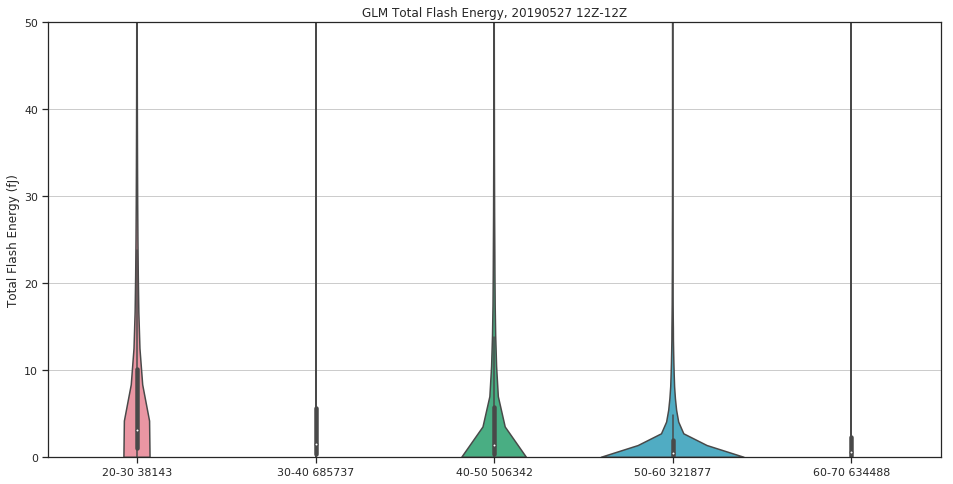

In [47]:
fig1 = plt.figure(figsize=(16, 8))
fig1 = sns.violinplot(data=GLM_pd,cut=0)
plt.title('GLM Total Flash Energy, 20190527 12Z-12Z')
plt.ylabel('Total Flash Energy (fJ)')
plt.grid(True)
plt.ylim(0,50)
plt.savefig(save_loc+'FE_angle.png')
plt.show()

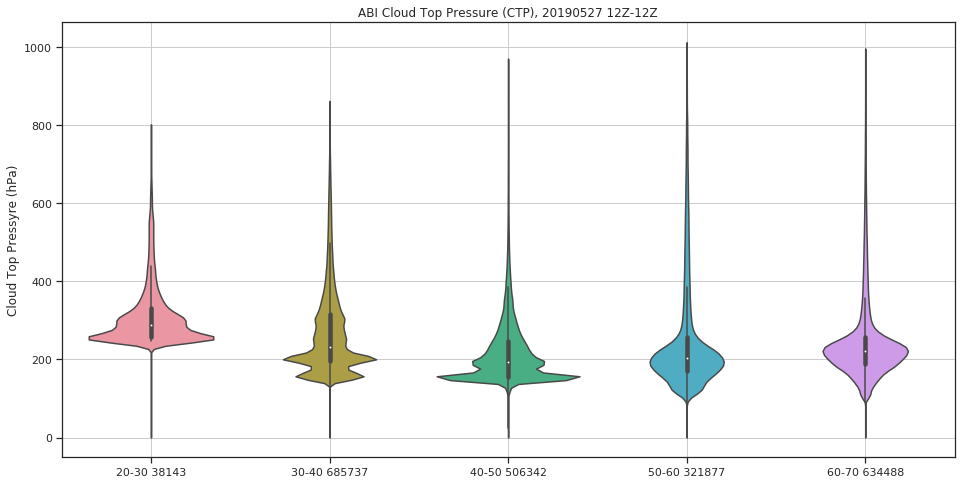

In [38]:
fig1 = plt.figure(figsize=(16, 8))
fig1 = sns.violinplot(data=ABI_pd,cut=0)
plt.title('ABI Cloud Top Pressure (CTP), 20190527 12Z-12Z')
plt.ylabel('Cloud Top Pressyre (hPa)')
plt.grid(True)
plt.savefig(save_loc+'CTP_angle.png')
plt.show()